# Music Generation with Deep Learning

### Music characteristics:

* Pitch
* Duration

## Imports

In [1]:
!pip3 install keras-visualizer
import sys, os, random, IPython, warnings, music21
from music21 import *
from IPython.display import Image, Audio
from collections import Counter
warnings.filterwarnings("ignore")
from keras_visualizer import visualizer 
warnings.simplefilter("ignore")
from music21 import note
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
np.random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount Google Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get MIDI music files

In [3]:
cwd = os.getcwd()
fileHalsey = cwd + "/drive/MyDrive/input/Halsey_music"
fileBeethoven = cwd + "/drive/MyDrive/input/classical-music/beeth"
filepath = fileBeethoven

all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        print(i)
        tr = filepath+"/"+i
        midi = converter.parse(tr)
        all_midis.append(midi)

beethoven_opus10_1.mid
beethoven_opus10_2.mid
beethoven_opus10_3.mid
pathetique_1.mid
pathetique_3.mid
pathetique_2.mid
beethoven_opus22_1.mid
beethoven_opus22_2.mid
beethoven_opus22_3.mid
beethoven_opus22_4.mid
mond_1.mid
mond_2.mid
mond_3.mid
waldstein_1.mid
waldstein_2.mid
waldstein_3.mid
appass_1.mid
appass_2.mid
appass_3.mid
beethoven_les_adieux_1.mid
beethoven_les_adieux_2.mid
beethoven_les_adieux_3.mid
beethoven_hammerklavier_1.mid
beethoven_hammerklavier_2.mid
beethoven_hammerklavier_3.mid
beethoven_hammerklavier_4.mid
elise.mid
beethoven_opus90_1.mid
beethoven_opus90_2.mid


## Create Pich and Duration Corpus

In [ ]:
def extract_notes(file):
    pitches = []
    durations = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    pitches.append(str(element.pitch))
                    durations.append(element.duration.quarterLength)
                elif isinstance(element, chord.Chord):
                    pitches.append(".".join(str(n) for n in element.normalOrder))
                    durations.append(element.duration.quarterLength)

    return pitches, durations

Corpus_pitches, Corpus_durations = extract_notes(all_midis)

## Create Corpus's mapping and reverse mapping

In [5]:
symb_notes = sorted(list(set(Corpus_pitches))) 
symb_durations = sorted(list(set(Corpus_durations))) 

L_pitches = len(Corpus_pitches) 
L_durations = len(Corpus_durations)  
L_symb_notes = len(symb_notes) 
L_symb_durations = len(symb_durations) 

mapping_notes = dict((c, i) for i, c in enumerate(symb_notes))  
mapping_durations = dict((c, i) for i, c in enumerate(symb_durations))  
reverse_mapping_notes = dict((i, c) for i, c in enumerate(symb_notes)) 
reverse_mapping_durations = dict((i, c) for i, c in enumerate(symb_durations))

print("Total number of notes: ", L_pitches)
print("Number of unique notes: ", L_symb_notes)
print("Total number of durations: ", L_durations)
print("Number of unique durations: ", L_symb_durations)

Total number of notes:  81312
Number of unique notes:  349
Total number of durations:  81312
Number of unique durations:  33


In [ ]:
count_num = Counter(Corpus_pitches)

rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times: ", len(rare_note))

### **Getting** a list of rare notes

In [ ]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times: ", len(rare_note))

### **Eliminating** the rare notes

In [ ]:
"""for element in Corpus_pitches:
    if element in rare_note:
        Corpus_pitches.remove(element)

print("Length of corpus after elemination the rare notes: ", len(Corpus_pitches))"""

### **Replacing** the removed notes with the most frequent one

In [ ]:
frequent_notes = []
for note, count in count_num.items():
    if count >= 100:
        frequent_notes.append(note)

for i in range(len(Corpus_pitches)):
    if Corpus_pitches[i] in rare_note:
        Corpus_pitches[i] = max(frequent_notes, key=lambda x: count_num[x])

print("Length of corpus after replacing the rare notes: ", len(Corpus_pitches))

## Create Sequences to training model

In [6]:
length = 40
note_features = []
duration_features = []
note_targets = []
duration_targets = []
for i in range(0, L_pitches - length, 1):
    note_feature = Corpus_pitches[i:i + length]
    duration_feature = Corpus_durations[i:i + length]
    target_note = Corpus_pitches[i + length]
    target_duration = Corpus_durations[i + length]
    note_features.append([mapping_notes[j] for j in note_feature])
    duration_features.append([mapping_durations[k] for k in duration_feature])
    note_targets.append(mapping_notes[target_note])
    duration_targets.append(mapping_durations[target_duration])

L_datapoints = len(note_targets)
print("Total number of sequences in the corpus: ", L_datapoints)

Total number of sequences in the corpus:  81272


## Reshape sequences for be in the format of model input

In [7]:
note_features = (np.reshape(note_features, (L_datapoints, length, 1))) / float(L_symb_notes)
duration_features = (np.reshape(duration_features, (L_datapoints, length, 1))) / float(L_symb_durations)
note_targets = tensorflow.keras.utils.to_categorical(note_targets)
duration_targets = tensorflow.keras.utils.to_categorical(duration_targets)

## Split data into Training and Test

In [8]:

X_note_train, X_note_test, X_duration_train, X_duration_test, y_target_note_train, y_target_note_test, y_target_duration_train, y_target_duration_test = train_test_split(
    note_features, duration_features, note_targets, duration_targets, test_size=0.2, random_state=42
)


## Build Model

In [13]:
note_input = Input(shape=(X_note_train.shape[1], X_note_train.shape[2]))
duration_input = Input(shape=(X_duration_train.shape[1], X_duration_train.shape[2]))

note_branch = LSTM(256, return_sequences=True)(note_input)
note_branch = Dropout(0.1)(note_branch)
note_branch = LSTM(128)(note_branch)

duration_branch = LSTM(256, return_sequences=True)(duration_input)
duration_branch = Dropout(0.1)(duration_branch)
duration_branch = LSTM(128)(duration_branch)

merged = Concatenate()([note_branch, duration_branch])
merged = Dense(128)(merged)
merged = Dropout(0.1)(merged)

output_note = Dense( y_target_note_train.shape[1], activation='softmax')(merged)
output_duration = Dense( y_target_duration_train.shape[1], activation='softmax')(merged)

model = Model(inputs=[note_input, duration_input], outputs=[output_note, output_duration])

opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              optimizer=opt,
              metrics=["accuracy"]),

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 40, 256)      264192      ['input_3[0][0]']                
                                                                                                  
 lstm_6 (LSTM)                  (None, 40, 256)      264192      ['input_4[0][0]']                
                                                                                            

## Train model

In [14]:
# BATCH_SIZE for Halsey is set for 128
# history = model.fit([X_note_train, X_duration_train], [y_target_note_train, y_target_duration_train], batch_size=128, epochs=150)
# BATCH_SIZE for Beethoven is set for 350
history = model.fit([X_note_train, X_duration_train], [y_target_note_train, y_target_duration_train], batch_size=350, epochs=150)

Epoch 1/150
186/186 [==============================] - 15s 41ms/step - loss: 6.0648 - dense_4_loss: 4.8141 - dense_5_loss: 1.2506 - dense_4_accuracy: 0.0220 - dense_5_accuracy: 0.6330
Epoch 2/150
186/186 [==============================] - 8s 40ms/step - loss: 5.7404 - dense_4_loss: 4.6421 - dense_5_loss: 1.0983 - dense_4_accuracy: 0.0258 - dense_5_accuracy: 0.6690
Epoch 3/150
186/186 [==============================] - 8s 41ms/step - loss: 5.6897 - dense_4_loss: 4.6189 - dense_5_loss: 1.0708 - dense_4_accuracy: 0.0273 - dense_5_accuracy: 0.6800
Epoch 4/150
186/186 [==============================] - 8s 41ms/step - loss: 5.6273 - dense_4_loss: 4.5941 - dense_5_loss: 1.0332 - dense_4_accuracy: 0.0296 - dense_5_accuracy: 0.6921
Epoch 5/150
186/186 [==============================] - 8s 43ms/step - loss: 5.5625 - dense_4_loss: 4.5765 - dense_5_loss: 0.9860 - dense_4_accuracy: 0.0313 - dense_5_accuracy: 0.7079
Epoch 6/150
186/186 [==============================] - 8s 41ms/step - loss: 5.4973 -

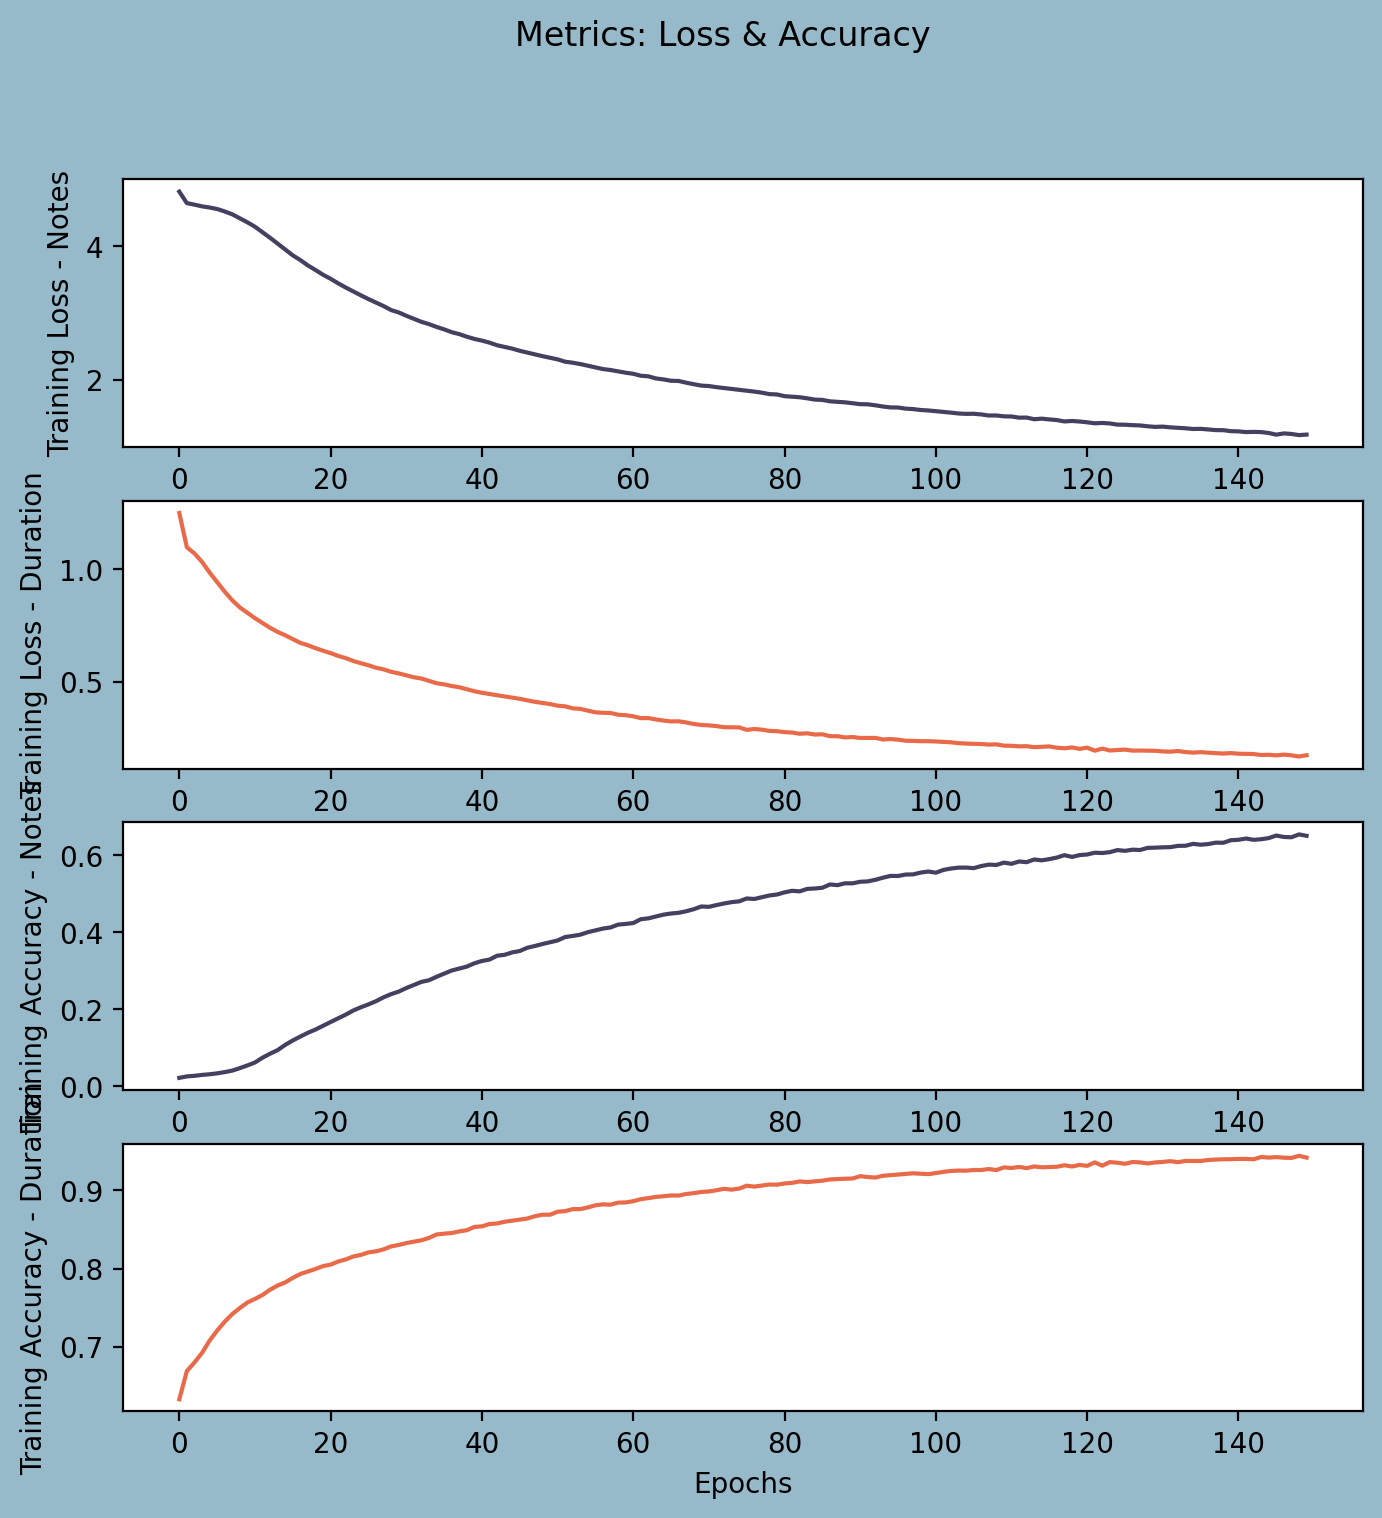

In [18]:
history_df = pd.DataFrame(history.history)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8), facecolor="#97BACB")
fig.suptitle("Metrics: Loss & Accuracy")

# Plot Pitches Loss
# sns.lineplot(data=history_df["dense_1_loss"], color="#444160", ax=ax1)
sns.lineplot(data=history_df["dense_4_loss"], color="#444160", ax=ax1)
ax1.set_ylabel("Training Loss - Pitches")
ax1.set_xlabel("Epochs")

# Plot Duration Loss
# sns.lineplot(data=history_df["dense_2_loss"], color="#E96A48", ax=ax2)
sns.lineplot(data=history_df["dense_5_loss"], color="#E96A48", ax=ax2)
ax2.set_ylabel("Training Loss - Duration")
ax2.set_xlabel("Epochs")

# Plot Pitches Accuracy
# sns.lineplot(data=history_df["dense_1_accuracy"], color="#444160", ax=ax3)
sns.lineplot(data=history_df["dense_4_accuracy"], color="#444160", ax=ax3)
ax3.set_ylabel("Training Accuracy - Pitches")
ax3.set_xlabel("Epochs")

# Plot Duration Accuracy
# sns.lineplot(data=history_df["dense_2_accuracy"], color="#E96A48", ax=ax4)
sns.lineplot(data=history_df["dense_5_accuracy"], color="#E96A48", ax=ax4)
ax4.set_ylabel("Training Accuracy - Duration")
ax4.set_xlabel("Epochs")

plt.show()

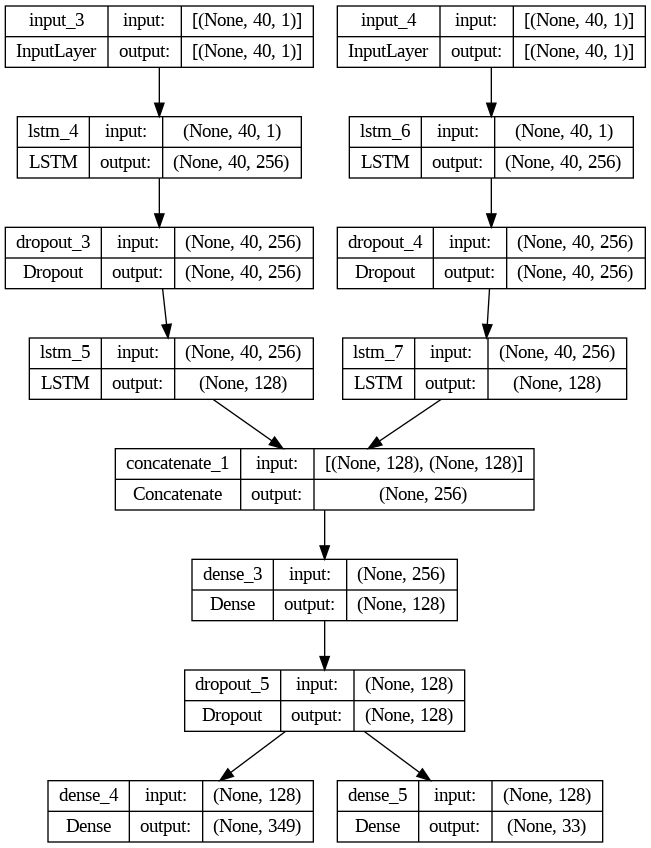

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='/content/model_architecture.png', show_shapes=True, show_layer_names=True)

In [24]:
def chords_n_notes(Snippet_notes, Snippet_durations):
    Melody = []
    offset = 0
    for note_val, duration_val in zip(Snippet_notes, Snippet_durations):
        # in case it is a chord
        if ("." in note_val or note_val.isdigit()):
            chord_notes = note_val.split(".")
            notes = [] 
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                note_snip.duration = duration.Duration(duration_val)
                note_snip.duration.quarterLength = duration_val
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            Melody.append(chord_snip)
        # in case it is a note
        else: 
            note_snip = note.Note(note_val)
            note_snip.offset = offset
            note_snip.duration.quarterLength = duration_val
            Melody.append(note_snip)

        offset += duration_val

    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

def Melody_Generator(Note_Count):
    seed_notes = X_note_test[np.random.randint(0, len(X_note_test) - 1)]
    seed_durations = X_duration_test[np.random.randint(0, len(X_duration_test) - 1)]
    Music = []
    Notes_Generated = []
    Durations_Generated = []
    
    for i in range(Note_Count):
        seed_notes_reshaped = seed_notes.reshape(1, length, 1)
        seed_durations_reshaped = seed_durations.reshape(1, length, 1)
        
        prediction_notes, prediction_durations = model.predict([seed_notes_reshaped, seed_durations_reshaped], verbose=0)
        
        # Convert predictions to probabilities
        prediction_notes = np.log(prediction_notes) / 1.0
        prediction_durations = np.log(prediction_durations) / 1.0
        
        exp_preds_notes = np.exp(prediction_notes)
        exp_preds_durations = np.exp(prediction_durations)
        
        prediction_notes = exp_preds_notes / np.sum(exp_preds_notes)
        prediction_durations = exp_preds_durations / np.sum(exp_preds_durations)
        
        index_note = np.argmax(prediction_notes)
        index_duration = np.argmax(prediction_durations)
        
        index_N_note = index_note / float(L_symb_notes)
        index_N_duration = index_duration / float(L_symb_durations)
        
        Notes_Generated.append(index_note)
        Durations_Generated.append(index_duration)
        
        Music_notes = [reverse_mapping_notes[char] for char in Notes_Generated]
        Music_durations = [reverse_mapping_durations[char] for char in Durations_Generated]
        
        Music = chords_n_notes(Music_notes, Music_durations)
        
        seed_notes = np.insert(seed_notes, len(seed_notes), index_N_note)
        seed_notes = seed_notes[1:]
        
        seed_durations = np.insert(seed_durations, len(seed_durations), index_N_duration)
        seed_durations = seed_durations[1:]
    
    Melody_midi = stream.Stream(Music)
    return Music_notes, Music_durations, Melody_midi


# Notes and durations created by the model
Music_notes, Music_durations, Melody = Melody_Generator(100)

In [27]:
cwd = os.getcwd()
filepath = cwd + "/drive/MyDrive/"
filename = 'beeth.h5'
model.save(filepath + filename)

In [28]:
cwd = os.getcwd()
filepath = cwd + "/drive/MyDrive/"
filename = 'Melody_Generated_Beeth_1.mid'
Melody.write('midi',filepath + filename)

'/content/drive/MyDrive/Melody_Generated_Beeth_1.mid'